1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class of original image: 5 == 5
Iteration 0: Loss = 4.787013530731201
Iteration 100: Loss = 0.0018231789581477642
Iteration 200: Loss = 0.0010425517102703452
Iteration 300: Loss = 0.0007057295297272503
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted confidence of adversarial image: 0.999151349067688
L2 norm between original and adversarial images: 0.7944312691688538


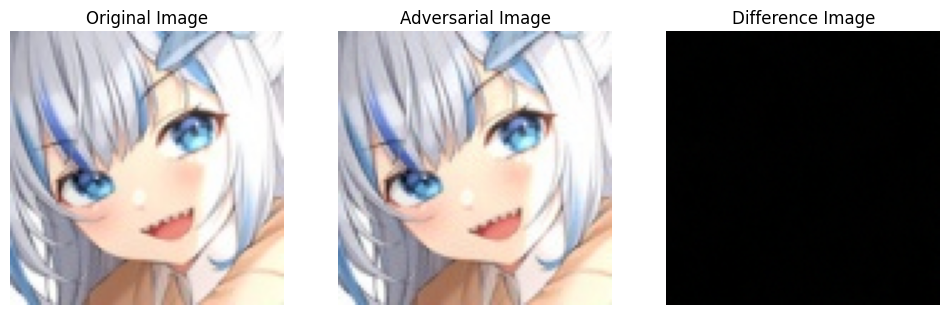

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

with open("./model_architecture.json", "r") as json_file:
  model_json = json_file.read()
model = model_from_json(model_json)
model.load_weights("./model.weights.h5")

# Parameters
img_size = 96
target_class_idx = 9

def load_and_preprocess_image(img_path):
  img = load_img(img_path, target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img.astype('float32') / 255.0 # normalize
  img = np.expand_dims(img, axis=0)
  return img

original_image = load_and_preprocess_image("./gura.png")
original_image_tensor = tf.Variable(original_image, dtype=tf.float32)

original_prediction = model.predict(original_image)
original_prediction = np.argmax(original_prediction)
print(f"Predicted class of original image: {original_prediction} == 5")

# Define loss function for the attack
def loss_fn(image_tensor, target_class_idx):
  predictions = model(image_tensor)

  # Classification loss: negative log likelihood of target class
  classification_loss = -tf.math.log(predictions[0, target_class_idx] + 1e-12)

  # Regularization loss: L2 norm of the perturbation
  regularization_loss = tf.reduce_sum(tf.square(image_tensor - original_image_tensor))

  # Total loss: classification loss + regularization loss
  total_loss = classification_loss + 0.1 * regularization_loss
  return total_loss

# Gradient descent parameters -> from grid search
learning_rate = 0.0004
num_iterations = 400

optimizer = tf.keras.optimizers.Adam(learning_rate)

for i in range(num_iterations):
  with tf.GradientTape() as tape:
    tape.watch(original_image_tensor)
    loss = loss_fn(original_image_tensor, target_class_idx)
  grads = tape.gradient(loss, original_image_tensor)
  optimizer.apply_gradients([(grads, original_image_tensor)])

  if i % 100 == 0:
    print(f"Iteration {i}: Loss = {loss.numpy()}")

adversarial_image = np.clip(original_image_tensor.numpy().squeeze(), 0, 1)
adversarial_prediction = model.predict(np.expand_dims(adversarial_image, axis=0))
print(f"Predicted confidence of adversarial image: {adversarial_prediction[0][9]}")

l2_norm = np.linalg.norm(adversarial_image - original_image.squeeze())
print(f"L2 norm between original and adversarial images: {l2_norm}")

# Display the original and adversarial images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image.squeeze())
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(adversarial_image)
plt.title('Adversarial Image')
plt.axis('off')

difference_image = np.abs(adversarial_image - original_image.squeeze())
plt.subplot(1, 3, 3)
plt.imshow(difference_image, cmap='hot')
plt.title('Difference Image')
plt.axis('off')

plt.show()

In [66]:
from base64 import b64encode

plt.imsave('adversarial.png', adversarial_image)
print(b64encode(open('adversarial.png', 'rb').read()).decode())

iVBORw0KGgoAAAANSUhEUgAAAGAAAABgCAYAAADimHc4AAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAWNBJREFUeJxV/devpVma3on9lvvctse7OGEzIyJ9ZZnMqu5qtiW7m2RzmkMrcTAzAAFdSTe6kP4B3ehCEARoIANwBBDkSCNqSHY3m+2rqrtcV2VVZVa6yPA+jj9nn+0+t4wu1s5sKQIBBCL2OYj4vrVe87zP87zif/9//L8F6UFLxfaFbbKsYHI+xtmGre1thAgYKfFCEKwlzzs8ffEUgWR7e5d5OWapvwRK0LaeLBfYtqEqKwa9IR4QQqGTjKb2eFFTzytWVpawdYVIUppWkCeCqqpom4blQZeqbNCpIbSOb/3FX/C1r73D+vo6/Y0NtFaEtkYmitB4agsPjqbcfXHGXhN49OQps6fPWF/qolTg4qUtVoZDnAg4oKpqrActJK5quH37NhevXSMrMpRU7G5s0u8qTg5e8NPvfIuV/pDXbryEQPLH3/lLtq5d4yu/8qskWU5w4GxNroG24fnTh6wuDbjx8jW08BidkGgBtBAk5awCFHsnB6ytrKGN1CgjMVITvMQ5TwCUVDjrUSoglEIBQWuEEiQ6YTqbYa3FWY/1DiUkUgrwoILCtg6HQ4uEAHhAJgJfCZQU1PM5aSfD+oA0AAIlQChBVZZokyPwSJ3w6muv8cMf/pBf/Y2/zbJQ+LZBJwkSi5cCLwI760ucTUuePT5id32VZ2dH3L71Cd/85b+FUAltCAhAyUA1n+NdQOcZZVly8eIuK8tLLC8v0y0yfF3x0c/f59m9u7x281VevfEyvSyjaVp++7f+Dp89fsKDW5+wsrWJ8Aq85cxb2nLG+uoS3U7G9HzMcKmHEgEhFaCYz0qSJGU8mVAUHfJO